# Image segmentation with a U-Net-like architecture
### 使用U-Net网络结构实现图像实例分割

原文链接：https://keras.io/examples/vision/oxford_pets_image_segmentation/

## Note
这个例子是实例分割，将图像中的目标扣出来，需要使用到牛津大学的一个数据集，最好挂上梯子下。如果发现在IDE中挂上梯子下载也很慢可以执行以下操作：  

Linux：
1. 在终端里配置好 export HTTP_PROXY以及 HTTPS_PROXY
2. 从终端中启动IDE，VS code的命令是 “code”

Windows：
1. 终端中输入 conda activate 你的环境
2. 从终端中启动IDE，VS code的命令是 “code”

Windows用户如果还是下载很慢的话，最简单粗暴的方式就是将后面的链接直接在浏览器中打开，只要挂上梯子了下载速度能跑满带宽。

---------------

## Download the data

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

^C


## 解压文件

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

解压后可以得到两个文件夹：
```python
images/
    Abyssinian_1.jpg    31.6 KB         (600, 400, 3)
    Abyssinian_2.jpg    31.9 KB         (600, 473, 3)
    ....
annotations/
    trimaps/
        ._Abyssinian_1.png  240 Byte
        ._Abyssinian_2.png  240 Byte
        ...
        Abyssinian_1.png    2.92 KB     (600, 400)
        Abyssinian_2.png    3.41 KB     (600, 473)
    xmls/
        Abyssinian_1.xml    493 Byte
        Abyssinian_10.xml   494 Byte
        ...
    README
    others
```
images文件夹是目标图像文件夹，里面有大量的猫和狗的RGB彩色照片；  
annotations文件夹中只需要用到trimaps目录下的内容，这个其实就是掩膜，只不过被保存成png格式了。  

在描述掩膜方面，规定了png图片中像素值如下：  
|value=1| value=2| value=3|
|---|---|---|
|Foreground|Background|Not classified|
|前景（物体）|背景（环境）|未分类（轮廓）|


实际上这个数据集的内容非常丰富，里面对图片中动物的类型也做了标注，用这个数据集做分类也是可以的。

------------

## Prepare paths of input images and target segmentation masks
## 准备输入图像和目标分割掩膜

In [1]:
import os

input_dir = 'images/'
target_dir = "annotations/trimaps/"
img_size = (160,160)
num_classes = 3
batch_size = 32

博主在这里的处理非常好，用sorted将文件路径进行排序，这样就可以避免因为平台排序差异的原因导致图像和掩膜没有对上号的情况。

In [2]:
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


-------------

## What does one input image and corresponding segmentation mask look like?
这里列举了一个原始图片和掩码图片的样例，如果你在这里想使用源码进行对比那么可以执行以下代码：  
```python
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# 显示原始图片
display(Image(filename=input_img_paths[9]))

# 显示掩码图片
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

```
为了能在GitHub上顺利地展示这个notbook，此处接从本地的样本库中读取了对应的两张

(-0.5, 599.5, 399.5, -0.5)

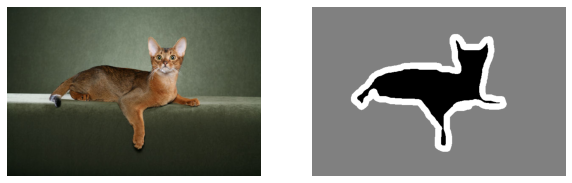

In [3]:
import matplotlib.pyplot as plt

origin_img = plt.imread("../images/CV_Img/Abyssinian_1.jpg")
masked_img = plt.imread("../images/CV_Img/Abyssinian_1.png")

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(origin_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masked_img, cmap='gray')
plt.axis("off")

--------------

## Prepare Sequence class to load & vectorize batches of data
### 准备一个类用来加载和矢量化数据

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

在这里构建了一个继承于 **keras.utils.Sequence** 的类，该类位文档于以下路径：  
[**Keras API reference / Utilities / Python & Numpy utilities**](https://keras.io/api/utils/python_utils/#sequence-class)  

根据这个类的描述：  
“**Base object for fitting to a sequence of data, such as a dataset.**”  
用于适配序列数据的的基类，如一个dataset类。  

“**Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.**”  
这个类是多线程安全的，这个类能够保证模型在单个epoch下，每个样本只被训练一次，但这个类并不使用与python的generators。【注意：这边的generator指的是python的生成器迭代器中的生成器，并不是神经网络中的生成器】  

同时要求实现以下方法：  
1. \_\_getitem\_\_ : 返回一个完整的batch。
2. \_\_len\_\_ :     batch_size 的个数，跑完一个epoch需要加载多个个batch。


StackOverflow 上有一个回答详细介绍了使用这个类加载数据的好处 [**Clarification about keras.utils.Sequence**](https://stackoverflow.com/questions/53620163/clarification-about-keras-utils-sequence)。  

大致好处有以下两点：  
1. 能够追踪训练集中那些batch已经被使用，哪些线程负责加载哪些batch，同时不会发生冲突；
2. 如果你需要加载的数据非常大，那么这个类可以通过多线程的方式大幅缩短加载时间

In [5]:
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        """返回的是一个根据batch索引的二元组，第一个为原始图像，第二个为掩膜图像"""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # 这里出现了python的一个使用技巧：可以用 “+” 来组织shape
        # (10,)+(15,12)+(3,) = (10,15,12,3)
        # 但要注意，如果一个括号里只有一个数，必须要带上 “,” 否则会报错
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # 因为掩膜图像像素值为 1,2,3 在这里将其整合成 0,1,2
            y[j] -= 1
        return x, y

-------------

## Prepare U-Net Xception-style model

在构建模型的时候使用了 [**SeparableConv2D**](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) 来代替 [**Conv2D**](https://keras.io/api/layers/convolution_layers/convolution2d/)。  

这里推荐阅读 **Shaw_Road** 的博客 [keras中Conv,SeparableConv2D,DepthwiseConv2D三种卷积过程浅谈](https://blog.csdn.net/shawroad88/article/details/95222082)。  
如果可以翻墙，那么 **Chi-Feng Wang** 的博客[A Basic Introduction to Separable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)讲的更详细。  

对于初学者而言，可以简单记住 SeparableConv2D 比 Conv2D **更快**，并且 MobileNet 中使用到了这个以加速计算。

In [6]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # Entry block
    # 模型头部
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual 旁支残差

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual 残差投影，这一步是为了在深度层面上对齐
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual 残差附加
        previous_block_activation = x  # Set aside next residual 留出下一个残差

    ### [Second half of the network: upsampling inputs] ###
    # 因为前半部分使用了多次MaxPooling2D来降采样，现在要升回去
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual 残差投影
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual 残差附加
        previous_block_activation = x  # Set aside next residual 留出下一个残差

    # Add a per-pixel classification layer
    # 为每个像素添加一个分类层，并使用 softnax 激活函数将值应设至 [0,1] 之间
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

很多初学者可能不理解为什么在最后一个输出的卷积层中使用 “**softmax**” ，因为在之前的学习中这个激活函数通常被用在分类问题上。此处其实是博主做了一个转化。  

在U-Net最初的文章 [**U-net: Convolutional networks for biomedical image segmentation**](extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Flink.springer.com%2Fcontent%2Fpdf%2F10.1007%2F978-3-319-24574-4_28.pdf) 中，作者使用的是加权 softmax 函数作为整个模型的损失函数，整个任务是完成等**多类别**医学图像语义分割，按照文章中思想，在计算损失函数的时候引入softmax，则需要额外定义一个loss function，而这一步被博主简化入最后一个卷积层中去了。

**stochastic_zeitgeist**在 Stack Overflow 上相关问题 [“**regarding the output format for semantic segmentation**”](https://stats.stackexchange.com/questions/246287/regarding-the-output-format-for-semantic-segmentation) 中总结了语义分割网络最后一层激活函数的使用场景。  
|sigmoid|softmax|
|---|----|
|分割类别为两类|分割类别为多类|

可以粗略地理解成 softmax 函数能够根据输入图像的内容对输出图像进行像素级别的投票，因为是多类型的语义分割问题，所以使用 softmax，而如果是二元问题那么 sigmoid 函数也可以使用。

In [7]:
# Free up RAM in case the model definition cells were run multiple times
# 释放掉内存中其他的模型，这个操作是为了防止多次生产模型占用了内存。
keras.backend.clear_session()

In [8]:
model = get_model(img_size, num_classes)

-----------

## Set aside a validation split

将路径列表拆分成训练集和测试集。至此也能发现，图像数据仍旧没有加载进内存，我们一直操作的是图像的文件路径。

In [9]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [10]:
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

-------------

## Train the model

在这里原文中使用的 **RMSProp** 优化器，实际上 **Adam** 是目前应用最为广泛且最可靠的优化器，但这里按照原文进行设置。
```python
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
```

In [11]:
epochs = 5

In [12]:
model.compile(
    optimizer=keras.optimizers.RMSprop(), 
    loss=keras.losses.SparseCategoricalCrossentropy()
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/5
199/199 [==============================] - 48s 202ms/step - loss: 1.0019 - val_loss: 3.9540
Epoch 2/5


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


199/199 [==============================] - 40s 202ms/step - loss: 0.5028 - val_loss: 3.5464
Epoch 3/5
199/199 [==============================] - 40s 202ms/step - loss: 0.4267 - val_loss: 0.4437
Epoch 4/5
199/199 [==============================] - 40s 201ms/step - loss: 0.3815 - val_loss: 0.5460
Epoch 5/5
199/199 [==============================] - 40s 202ms/step - loss: 0.3462 - val_loss: 0.3799


-----------

## Visualize predictions
随机抽取一张图片对比下模型的结果，这里我偷懒了就没有用matplotlib写，勤快的同学可以尝试将其改写成matplotlib的方法

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

In [14]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [15]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

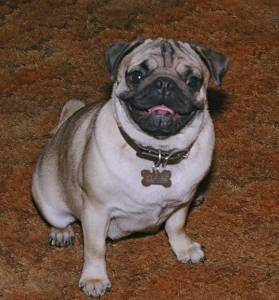

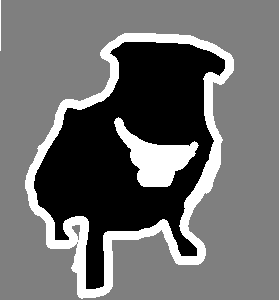

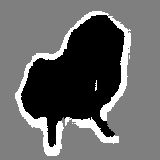

In [16]:
i = 10

display(Image(filename=val_input_img_paths[i]))

img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)

从效果上来看，这模型确实很强，仅仅在5个epochs下就可以达到对大致轮廓的分割，后面其实可以试下将最后个卷积层的 softmax 函数改成 sigmoid 函数看看会有多大差异。